In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2

from tqdm import tqdm
from pprint import pprint

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


### Dataset images

You can find dataset images celeba in here: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

Download it, and create a directory called "./img_align_celeba", save all images right there. 

# 1) Load data

In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

## 1.1) Slice dataset in train-val-test

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

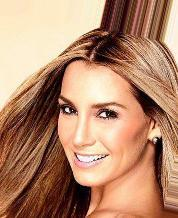

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

## 1.2) Let's preprocessing all images with tf dataset

In [8]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [25]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x), n_outputs=1)
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x), n_outputs=1)
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x), n_outputs=1)
)

## 2) Create simple VAE Architecture (with Sobel loss function)

We will use sobel filter to build a function that will help neural network learn high frequency features.

In [26]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [27]:
codings_size = 100

inputs = keras.layers.Input(shape=[128, 128, 3])
# Z = keras.layers.Conv2D(16, 4, padding="same", activation="relu")(inputs)
# Z = keras.layers.MaxPool2D(pool_size=2)(Z)

Z = keras.layers.Conv2D(32, 4, padding="same", activation="relu")(inputs)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(64, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(128, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(256, 4, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
Z = keras.layers.Flatten()(Z)

codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

# ---------

codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
x = keras.layers.Reshape((4, 4, 256))(x)

x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(64, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2DTranspose(32, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)


x = keras.layers.Conv2DTranspose(3, 4, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.BatchNormalization()(x)


outputs = keras.layers.Reshape([128, 128, 3])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [28]:
_, _, codings = variational_encoder([inputs])
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)

variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))

In [30]:
variational_ae.compile(loss='mse', optimizer="adam")

In [31]:
dataset_train = ds_train.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)
dataset_val = ds_val.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)

In [32]:
from IPython.display import clear_output
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

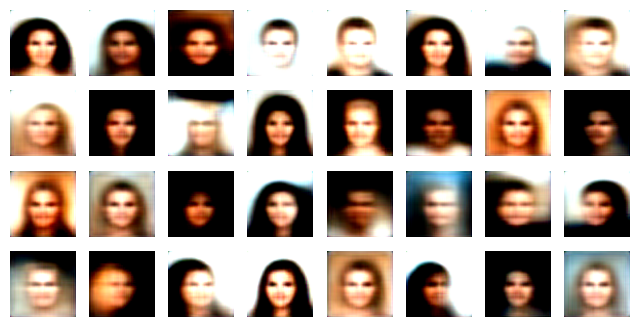

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.81s/it]


In [34]:
for epoch in tqdm(range(1)):
    for X_batch_1 in dataset_train:
        # Fase 0 - Treinar a rede VAE
        
        variational_ae.train_on_batch(X_batch_1, X_batch_1)
        generated_images = variational_ae(X_batch_1)
    plot_multiple_images(generated_images.numpy(), 8)
    plt.show()

In [54]:

'''

Saving models after training...

'''

# variational_ae.save('simple_vae/autoencoder/simple_vae_autoencoder.keras')
# variational_encoder.save('simple_vae/encoder/simple_vae_encoder.keras')
# variational_decoder.save('simple_vae/decoder/simple_vae_decoder.keras')

'\n\nSaving models after training...\n\n'

## 3) Organizing Architecture and define Sobel Loss

In [36]:
'''

In here, we define three different sobel losses. Feel free to use any of them and test it.


'''



def sobel_loss(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction

    loss_sobel_x = tf.reduce_sum( tf.abs(sobel_x - sobel_x_hat) , axis=-1)
    loss_sobel_y = tf.reduce_sum( tf.abs(sobel_y - sobel_y_hat) , axis=-1)
    
    loss_sobel_x = gamma * tf.reduce_mean(loss_sobel_x) / (128. * 128.)
    loss_sobel_y = gamma * tf.reduce_mean(loss_sobel_y) / (128. * 128.)
    

    return loss_sobel_x + loss_sobel_y

def quadratic_sobel_loss(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction

    loss_sobel_x = tf.reduce_sum( tf.square(sobel_x - sobel_x_hat) , axis=-1)
    loss_sobel_y = tf.reduce_sum( tf.square(sobel_y - sobel_y_hat) , axis=-1)
    
    loss_sobel_x = gamma * tf.reduce_mean(loss_sobel_x) / (128. * 128.)
    loss_sobel_y = gamma * tf.reduce_mean(loss_sobel_y) / (128. * 128.)
    

    return loss_sobel_x + loss_sobel_y

def complete_sobel_loss(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction
    
    gradient_input = sobel_x ** 2 + sobel_y ** 2
    
    gradient_reconstruction = sobel_x_hat ** 2 + sobel_y_hat ** 2
    
    return gamma * tf.reduce_mean(tf.abs(gradient_input - gradient_reconstruction)) / (128. * 128.)

In [37]:
def build_vae_sobel_model(codings_size=100):

    inputs = keras.layers.Input(shape=[128, 128, 3])

    Z = keras.layers.Conv2D(32, 4, padding="same", activation="relu")(inputs)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(64, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(128, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(256, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
    Z = keras.layers.Flatten()(Z)

    codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

    # ---------

    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.Model(
        inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
    x = keras.layers.Reshape((4, 4, 256))(x)

    x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(64, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(32, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    x = keras.layers.Conv2DTranspose(3, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    outputs = keras.layers.Reshape([128, 128, 3])(x)
    variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    
    _, _, codings = variational_encoder([inputs])
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)

    variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))
    
    return variational_encoder, variational_decoder, variational_ae

In [38]:
dataset_train = ds_train.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)
dataset_val = ds_val.shuffle(1000).batch(32, drop_remainder=True).prefetch(1)

In [39]:
encoder, decoder, variational_ae = build_vae_sobel_model()

In [41]:
from IPython.display import clear_output
def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

In [136]:
def plot_losses(history):
    epochs = np.array(list(range(1, len(history['loss_reconstruction']) + 1))) * 10
    
    plt.figure(figsize=(6, 6))
    
    plt.plot(epochs, history['loss_reconstruction'], 'b', label='Loss Reconstruction')
    plt.plot(epochs, history['loss_sobel'], 'r', label='Loss Sobel')
    plt.plot(epochs, history['loss_dkl'], 'g', label='Loss DKL')
    plt.plot(epochs, history['total_loss'], 'y', label='Total Loss')
    
    plt.title('Training Losses')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.grid(True)
    plt.show()

In [137]:
def print_logs(history, epoch, total_epochs, n_batch, step):
    print('------------Losses---------------')
    print('loss_reconstruction: ',  history['loss_reconstruction'][-1])
    print('loss_sobel: ',  history['loss_sobel'][-1])
    print('loss_dkl: ',  history['loss_dkl'][-1])
    print('total_loss: ',  history['total_loss'][-1])
    print('---------------------------------')
    print(f'Epoch: {epoch}/{total_epochs}')
    print(f'N Batch: {n_batch}')
    print(f'Step: {step}')

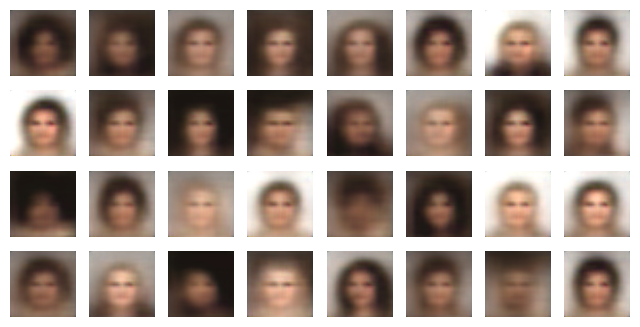

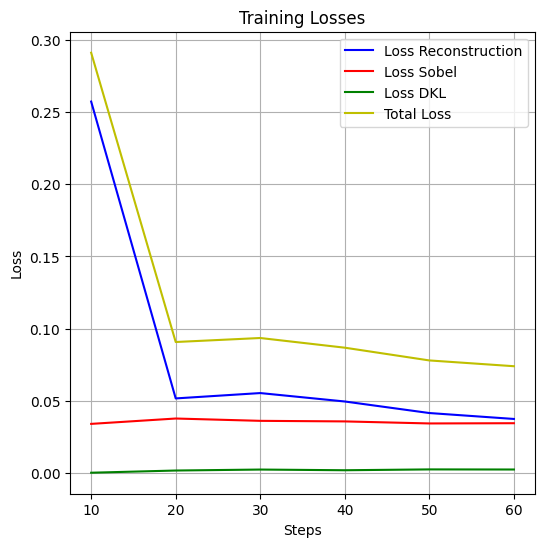

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.03728772, shape=(), dtype=float32)
loss_sobel:  tf.Tensor(0.034332883, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.0022329828, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.07385358, shape=(), dtype=float32)
---------------------------------
Epoch: 0/1
N Batch: 500
Step: 500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.01s/it]


In [45]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
SobelLoss = sobel_loss
optimizer = keras.optimizers.Adam()
total_epochs = 1
step = 0

for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in dataset_train:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1)
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1, X_reconstructions)
            # Loss sobel
            loss_sobel = SobelLoss(X_batch_1, X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction + loss_sobel
        
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1)
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1


In [46]:
'''

Saving models after training...

'''

# variational_ae.save('vae_sobel_loss/autoencoder/vae_sobel_autoencoder.keras')
# variational_encoder.save('vae_sobel_loss/encoder/vae_sobel_encoder.keras')
# variational_decoder.save('vae_sobel_loss/decoder/vae_sobel_decoder.keras')

'\n\nSaving models after training...\n\n'

## 4) VAE with sobel loss function and Sin activation function

In [47]:
from keras import backend as K

def sin(x, beta=1.0):
    return K.sin(beta * x)

In [48]:
def build_vae_sobel_model_siren(codings_size=100):

    inputs = keras.layers.Input(shape=[128, 128, 3])

    Z = keras.layers.Conv2D(32, 1, padding="same", activation='tanh')(inputs)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(64, 2, padding="same", activation=sin)(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(128, 3, padding="same", activation=sin)(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(256, 4, padding="same", activation="sigmoid")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
    Z = keras.layers.Flatten()(Z)

    codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

    # ---------

    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.Model(
        inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
    x = keras.layers.Reshape((4, 4, 256))(x)

    x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='tanh')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation=sin)(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation=sin)(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(32, 2, padding='same', activation=sin)(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    x = keras.layers.Conv2DTranspose(3, 1, padding='same', activation='sigmoid')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    outputs = keras.layers.Reshape([128, 128, 3])(x)
    variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    
    _, _, codings = variational_encoder([inputs])
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)

    variational_ae.add_loss(tf.reduce_mean(latent_loss) / (128. * 128.))
    
    return variational_encoder, variational_decoder, variational_ae

In [49]:
encoder, decoder, variational_ae = build_vae_sobel_model_siren()

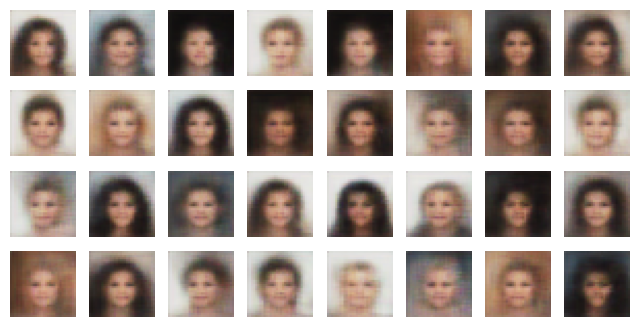

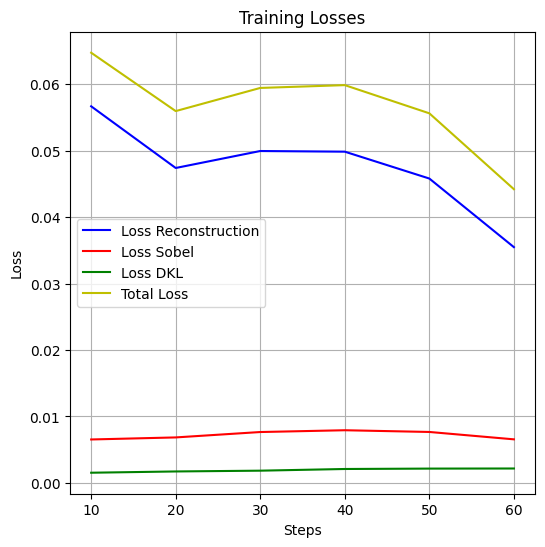

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.035471216, shape=(), dtype=float32)
loss_sobel:  tf.Tensor(0.0065523125, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(0.002165456, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.044188984, shape=(), dtype=float32)
---------------------------------
Epoch: 0/1
N Batch: 500
Step: 500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.86s/it]


In [52]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
total_epochs = 1
step = 0
for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in dataset_train:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1)
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1, X_reconstructions)
            # Loss sobel
            loss_sobel = complete_sobel_loss(X_batch_1, X_reconstructions, gamma=512.0)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction + loss_sobel
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1)
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1

In [53]:
'''

Saving models after training...

'''

# variational_ae.save('vae_sobel_loss_siren/autoencoder/vae_sobel_siren_autoencoder.keras')
# variational_encoder.save('vae_sobel_loss_siren/encoder/vae_sobel_siren_encoder.keras')
# variational_decoder.save('vae_sobel_loss_siren/decoder/vae_sobel_siren_decoder.keras')

'\n\nSaving models after training...\n\n'

## 5) beta-VAE with low DKL and sobel loss

In [132]:
def build_beta_vae_sobel_model(codings_size=100, beta=1.0):

    inputs = keras.layers.Input(shape=[128, 128, 3])

    Z = keras.layers.Conv2D(32, 4, padding="same", activation="relu")(inputs)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(64, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(128, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.Conv2D(256, 4, padding="same", activation="relu")(Z)
    Z = keras.layers.MaxPool2D(pool_size=2)(Z)
    Z = keras.layers.BatchNormalization()(Z)

    Z = keras.layers.GlobalAvgPool2D()(Z) # Output 256
    Z = keras.layers.Flatten()(Z)

    codings_mean = keras.layers.Dense(codings_size)(Z)  # μ
    codings_log_var = keras.layers.Dense(codings_size)(Z)  # γ

    # ---------

    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.Model(
        inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(4 * 4 * 256)(decoder_inputs)
    x = keras.layers.Reshape((4, 4, 256))(x)

    x = keras.layers.Conv2DTranspose(256, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(128, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(64, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2DTranspose(32, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    x = keras.layers.Conv2DTranspose(3, 4, padding='same', activation='relu')(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.BatchNormalization()(x)


    outputs = keras.layers.Reshape([128, 128, 3])(x)
    variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    
    _, _, codings = variational_encoder([inputs])
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=[reconstructions])

    latent_loss = -0.5 * tf.reduce_sum(
        1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
        axis=-1)

    variational_ae.add_loss(beta * tf.reduce_mean(latent_loss) / (128. * 128.))
    
    return variational_encoder, variational_decoder, variational_ae

In [133]:
def complete_sobel_loss_w_MAE(X_input, X_reconstruction, gamma=32.0):

    sobel = tf.image.sobel_edges(X_input)
    sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
    sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

    sobel_hat = tf.image.sobel_edges(X_reconstruction)
    sobel_y_hat = sobel_hat[:, :, :, :, 0] # sobel in y-direction
    sobel_x_hat = sobel_hat[:, :, :, :, 1] # sobel in x-direction
    
    gradient_input = sobel_x ** 2 + sobel_y ** 2
    
    gradient_reconstruction = sobel_x_hat ** 2 + sobel_y_hat ** 2
    
    return gamma * MAE(gradient_input, gradient_reconstruction)

In [140]:
encoder, decoder, variational_ae = build_beta_vae_sobel_model(beta=0.001)

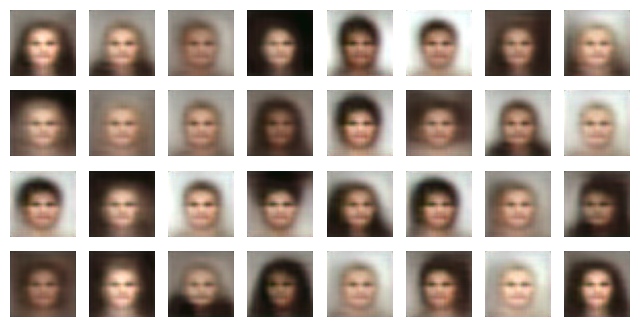

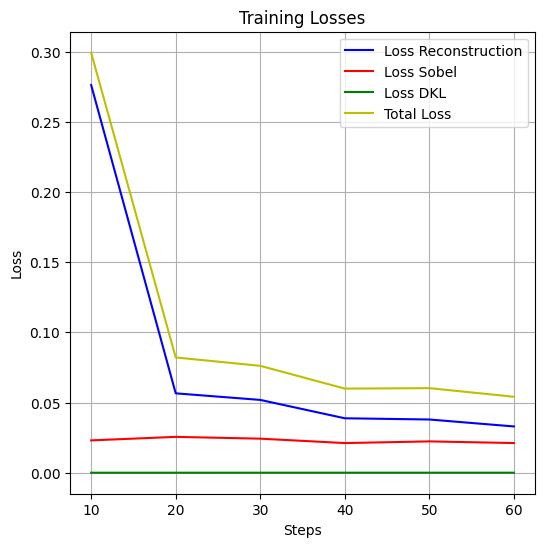

------------Losses---------------
loss_reconstruction:  tf.Tensor(0.032965794, shape=(), dtype=float32)
loss_sobel:  tf.Tensor(0.02113453, shape=(), dtype=float32)
loss_dkl:  tf.Tensor(1.6383578e-05, shape=(), dtype=float32)
total_loss:  tf.Tensor(0.054116707, shape=(), dtype=float32)
---------------------------------
Epoch: 0/1
N Batch: 500
Step: 500


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:54<00:00, 54.31s/it]


In [141]:
history = {
            'loss_reconstruction': [],
            'loss_sobel': [],
            'loss_dkl': [],
            'total_loss': []
        }

MSE = keras.losses.MeanSquaredError()
MAE = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam()
total_epochs = 1
step = 0
for epoch in tqdm(range(total_epochs)):
    n_batch = 0
    for X_batch_1 in dataset_train:
        with tf.GradientTape() as tape:
            # Forward pass.
            X_reconstructions = variational_ae(X_batch_1)
            # Loss reconstruction
            loss_reconstruction = MSE(X_batch_1, X_reconstructions)
            # Loss sobel
            loss_sobel = complete_sobel_loss_w_MAE(X_batch_1, X_reconstructions, gamma=0.1)
            # Add extra loss terms to the loss value.
            loss_total = sum(variational_ae.losses) + loss_reconstruction + loss_sobel
        gradients = tape.gradient(loss_total, variational_ae.trainable_weights)
        optimizer.apply_gradients(zip(gradients, variational_ae.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_reconstruction'].append(loss_reconstruction)
            history['loss_sobel'].append(loss_sobel)
            history['loss_dkl'].append(sum(variational_ae.losses))
            history['total_loss'].append(loss_total)
    
            generated_images = variational_ae(X_batch_1)
            plot_multiple_images(generated_images.numpy(), 8)
            plot_losses(history)
            print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1

## Extra - Objective with sobel filter

We want minimize error by difference of gradients, so we can write another loss function:

$$L_{sobel} = f_{sobel}(input) - f_{sobel}(reconstruction)$$

In [66]:
sample = X_batch_1[0:1]
reconstruction = variational_ae(sample)

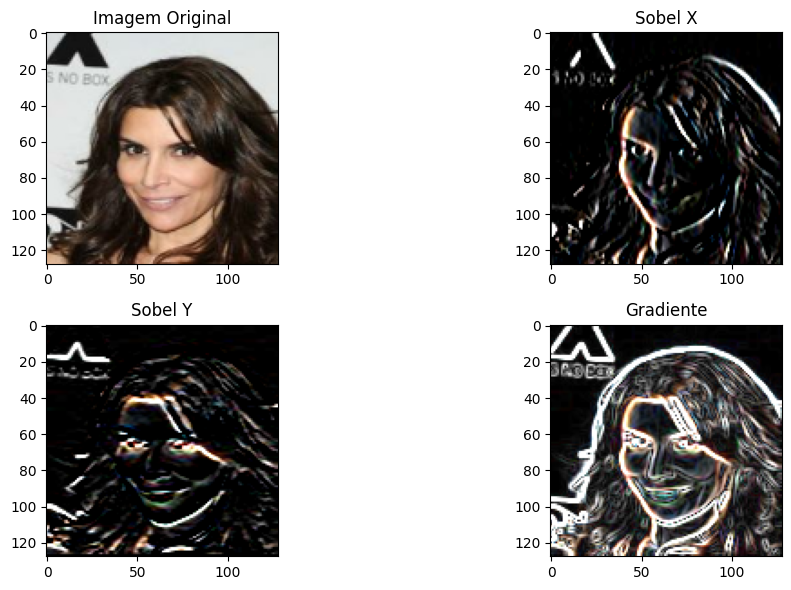

In [68]:
# Aplicar filtro de Sobel
# sobel_x = cv2.Sobel(sample.numpy(), cv2.CV_64F, 1, 0, ksize=3)
# sobel_y = cv2.Sobel(sample.numpy(), cv2.CV_64F, 0, 1, ksize=3)
sobel = tf.image.sobel_edges(sample)
sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

# Calcular o gradiente aproximado
gradiente = tf.sqrt(sobel_x**2 + sobel_y**2)

# Mostrar as imagens
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(sample[0], cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 2, 2)
plt.imshow(sobel_x[0], cmap='gray')
plt.title('Sobel X')

plt.subplot(2, 2, 3)
plt.imshow(sobel_y[0], cmap='gray')
plt.title('Sobel Y')

plt.subplot(2, 2, 4)
plt.imshow(gradiente[0], cmap='gray')
plt.title('Gradiente')

clear_output()
plt.tight_layout()
plt.show()

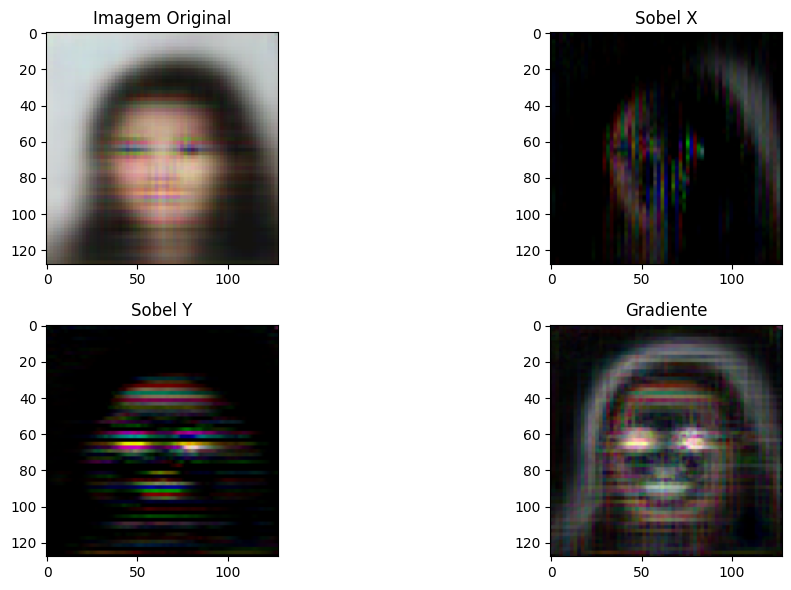

In [69]:
# Aplicar filtro de Sobel
# sobel_x = cv2.Sobel(sample.numpy(), cv2.CV_64F, 1, 0, ksize=3)
# sobel_y = cv2.Sobel(sample.numpy(), cv2.CV_64F, 0, 1, ksize=3)
sobel = tf.image.sobel_edges(reconstruction)
sobel_y = sobel[:, :, :, :, 0] # sobel in y-direction
sobel_x = sobel[:, :, :, :, 1] # sobel in x-direction

# Calcular o gradiente aproximado
gradiente_reconstruction = tf.sqrt(sobel_x**2 + sobel_y**2)

# Mostrar as imagens
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(reconstruction[0], cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 2, 2)
plt.imshow(sobel_x[0], cmap='gray')
plt.title('Sobel X')

plt.subplot(2, 2, 3)
plt.imshow(sobel_y[0], cmap='gray')
plt.title('Sobel Y')

plt.subplot(2, 2, 4)
plt.imshow(gradiente_reconstruction[0], cmap='gray')
plt.title('Gradiente')

clear_output()
plt.tight_layout()
plt.show()

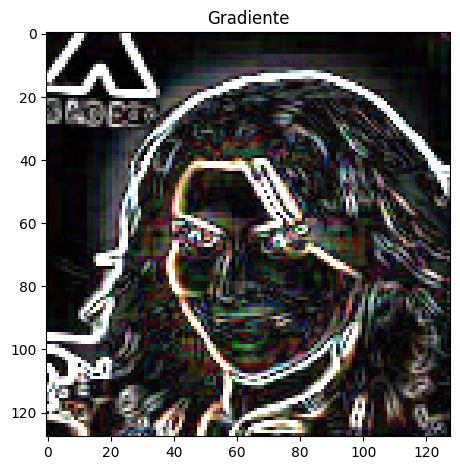

In [72]:
'''

Bellow, we can see what we want to minimize with sobel loss. The difference between gradients must be zero.

'''

plt.imshow(tf.abs(gradiente[0] - gradiente_reconstruction[0]), cmap='gray')
plt.title('Gradiente')

clear_output()
plt.tight_layout()
plt.show()

## 3) DCGAN 

In [125]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator = tf.keras.Sequential([
    keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(4 * 4 * 256),
    tf.keras.layers.Reshape((4, 4, 256)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    keras.layers.UpSampling2D(2),

    tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])


discriminator = tf.keras.Sequential([
    keras.layers.Input(shape=[128, 128, 3]),
    tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),

    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [126]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [127]:
discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 64, 64, 32)        2432      
                                                                 
 dropout_14 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 64)        51264     
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 flatten_12 (Flatten)        (None, 65536)             0         
                                                                 
 dense_30 (Dense)            (None, 1)                 65537     
                                                                 
Total params: 119,233
Trainable params: 0
Non-trainab

In [128]:
generator.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 4096)              413696    
                                                                 
 reshape_17 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_73 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_53 (Conv2D  (None, 8, 8, 32)         204832    
 Transpose)                                                      
                                                                 
 batch_normalization_74 (Bat  (None, 8, 8, 32)         128       
 chNormalization)                                                
                                                     

In [129]:
from tqdm import tqdm

def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs), position=1, desc='Progresso'):
        print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
        for X_batch in tqdm(dataset):
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            # print(generated_images.shape, X_batch[0].shape)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
            # extra code — plot images during training
            
        plot_multiple_images(generated_images.numpy()[:32], 8)
        plt.show()

In [130]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = ds_train.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

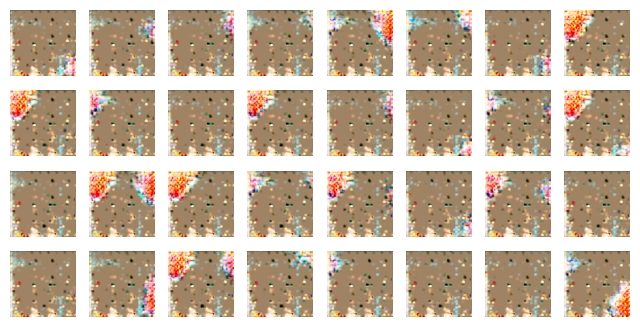


Progresso: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [06:05<00:00, 36.56s/it]


In [131]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

### New GAN

In [106]:
def plot_losses(history):
    epochs = np.array(list(range(1, len(history['loss_discriminator']) + 1))) * 10
    
    plt.figure(figsize=(6, 6))
    
    plt.plot(epochs, history['loss_discriminator'], 'b', label='loss_discriminator')
    plt.plot(epochs, history['loss_gan'], 'r', label='loss_gan')

    
    plt.title('Training Losses')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.grid(True)
    plt.show()

In [107]:
BinaryCrossEntropy = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.RMSprop()

In [108]:
# extra code – generates the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = ds_train.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
history = {
            'loss_discriminator': [],
            'loss_gan': [],
        }

generator, discriminator = gan.layers
step = 0
n_epochs = 10
for epoch in tqdm(range(n_epochs), position=1, desc='Progresso'):
    print(f"Epoch {epoch + 1}/{n_epochs}")  # extra code
    n_batch = 0
    for X_batch in tqdm(dataset):

        # phase 1 - training the discriminator
        with tf.GradientTape() as tape:
            # Forward pass.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            y1_hat = discriminator(X_fake_and_real)
            loss_discriminator = BinaryCrossEntropy(y1_hat, y1)
        gradients = tape.gradient(loss_discriminator, discriminator.trainable_weights)
        optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))


        # phase 2 - training the generator
        with tf.GradientTape() as tape:
            # Forward pass.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            y2_hat = gan(noise)
            # print(y2, y2_hat)
            loss_gan = BinaryCrossEntropy(y2_hat, y2)
        gradients = tape.gradient(loss_gan, gan.trainable_weights)
        optimizer.apply_gradients(zip(gradients, gan.trainable_weights))
        
        if step % 100 == 0:
            
            history['loss_discriminator'].append(loss_discriminator)
            history['loss_gan'].append(loss_gan)
    
            plot_multiple_images(generated_images.numpy()[:32], 8)
            plot_losses(history)
            # print_logs(history, epoch, total_epochs, n_batch, step)
            plt.show()
        n_batch += 1
        step += 1